- hr analyricsデータセットを使用して，2値分類問題を解く
- 各評価指標の値を計算し，考察する
- ビジネス要求と合わせ，採用する評価指標を決定する
- ビジネスインパクトを試算する
- ハガキによるDM送付の試算
- banking_datasetによる，利益曲線のプロット

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    matthews_corrcoef,
    roc_auc_score,
    precision_recall_curve,
    auc,)

TRAIN_FILE = '../data/hr_analytics/train.csv'
TEST_FILE = '../data/hr_analytics/test.csv'

RANDOM_STATE = 42

## データセットの説明

- `employee_id`
    - 従業員の固有ID
- `department`
    - 授業員の部門
- `region`
    - 就職先の地域
- `education`
    - 教育水準(学歴)
- `gender`
    - 従業員の性別
- `recruitment_channel`
    - 授業員の採用時の採用経路
- `no_of_trainings`
    - 前年度に完了したソフトスキル，テクニカルスキルなどのトレーニングの数
- `age`
    - 従業員の年齢
- `previous_year_rating`
    - 前年度の従業員評価
- `length_of_service`
    - 勤続年数(年)
- `awards_won?`
    - 前年度に受賞した場合は1，それ以外は0
- `avg_training_score`
    - 現在のトレーニング評価の平均点
- `is_promoted`
    - 昇進の推奨をされたかどうか
- `is_promoted` (目的変数)
    - 昇進した .. 1
    - 昇進しなかった .. 0

In [2]:
#
# データセットは以下の通り(今回はテストデータを使わない)
#

df_train = pd.read_csv(TRAIN_FILE)
print(df_train.shape)
display(df_train.head())

(54808, 13)


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,73,0


In [3]:
# 欠損値の確認
df_train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

- シンプルなロジスティック回帰モデルで予測し混同行列をプロットしてみる

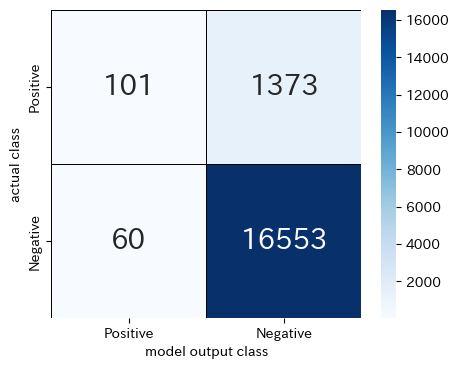

In [11]:
def label_encoding(df):
    """
    文字列で表されたラベルを0~N-1に変換し上書きする
    N = ラベル種類数
    """
    object_type_cols = [col for col in df.columns if df[col].dtypes == 'object']
    for object_type_col in object_type_cols:
        label_encoder = LabelEncoder()
        df[object_type_col] = label_encoder.fit_transform(df[object_type_col])
    return df

def standard_scale(X_train, X_val):
    """ 特徴の標準化 """
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)  # トレーニングデータをフィットして変換
    X_val_scaled = ss.transform(X_val)  # 検証データを変換（トレーニングデータで学習したパラメータを使用）
    return X_train_scaled, X_val_scaled

def run_preprocess(df_train):
    # Nanが含まれている行を削除(ロジスティック回帰が動かないため)
    remove_cols = ['previous_year_rating', 'education']
    df_train.drop(remove_cols, axis=1, inplace=True)
    df_train = label_encoding(df_train)
    return df_train


df_train = pd.read_csv(TRAIN_FILE)
# 前処理
df_train = run_preprocess(df_train)
y = df_train['is_promoted'].values # 教師ラベル
df_train.drop('is_promoted', axis=1, inplace=True)

# 学習データと検証データに分離
X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size=0.33, random_state=RANDOM_STATE)
# 標準化
X_train, X_val = standard_scale(X_train, X_val)

# ロジスティック回帰
clf = LogisticRegression(max_iter=200, random_state=RANDOM_STATE)
clf.fit(X_train, y_train)
# 推論
y_val_hat = clf.predict(X_val)

# 混同行列の作成
# label = [1, 0]とすることでPositiveが左側の列に来るように調整する
conf_matrix = confusion_matrix(y_val, y_val_hat, labels=[1, 0])
df_conf_matix = pd.DataFrame(conf_matrix, columns=['Positive', 'Negative'], index=['Positive', 'Negative'])

# 作成した混同行列をヒートマップの形でプロットする
plt.figure(figsize=(5,4))
sns.heatmap(
    df_conf_matix,
    fmt='d',
    annot=True,
    cmap='Blues',
    annot_kws={'fontsize': 20},
    linecolor='black',
    linewidths=0.5)
plt.xlabel('model output class')
plt.ylabel('actual class')
plt.show()

混同行列の見方

|TP|FN|
|---|---|
|FP|TN|

- True Positive (TP) : モデルが正例(Positive)と予測した正解した(True)数
- True Negative (TN) : モデルが負例(Negative)と予測して正解した(True)数
- False Positive (FP) : モデルが正例(Positive)と予測した間違えた(False)数
- False Negative (FN) : モデルが負例(Negative)と予測して間違えた(False)数

- 対角行列に近いほど良い予測と言える

- 結果の解釈
    - Posと予測されている数が少ない
        - 昇進評価の対象となる人数が少ない
    - 真のクラスのNegがPosの10倍以上である
        - Negの分類に注目すると，60+16553件のうち60件しか見逃している
        - 一方で，Posの方は，101+1373件のうち1373件も見逃している
        - 不均衡データの影響を受け，Negに分類されやすくなっている可能性がある
- 問題点
    - ビジネスの要求によってはモデルが適切ではない
    - 今回は，Posの取りこぼしを少なくしつつ，Negの取りこぼしを減らしたいので改良する必要がある
    - Posの取りこぼしを減らすとは，本来昇格すべき人を見逃さないようにすることで，Recallを上げることに相当
    - Negの取りこぼしを減らすとは，本来昇格すべきでない人を昇格させないようにするることで，Precisionを上げることに相当

今回学習したモデルについて，以下の評価指標の値を計算

- 正解率 (Accuracy)
- 適合率 (Precision)
- 再現率 (Recall)
- マシューズ相関係数 (Matthews correlation coefficient)
- $F_{\beta}-score$
- F1-Score
- G-Mean
- ROC-AUC
- PR-AUC
- pAUC

In [12]:
def g_mean_score(y, y_hat):
    # G-Meanを計算する
    tn, fp, fn, tp = confusion_matrix(y_val, y_val_hat).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    return math.sqrt(tpr * tnr), tpr, tnr

def pr_auc(X_val, y_val, clf):
    y_val_hat = clf.predict_proba(X_val)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_hat)
    return auc(recall, precision)

def p_auc(X_val, y_val, clf, max_fpr=0.2):
    y_val_hat = clf.predict_proba(X_val)[:, 1]
    return roc_auc_score(y_val, y_val_hat, max_fpr=max_fpr)

In [13]:
#
# 評価指標を計算
#

accuracy = accuracy_score(y_val, y_val_hat)
mcc = matthews_corrcoef(y_val, y_val_hat)
gmean, _, _ = g_mean_score(y_val, y_val_hat)
precision = precision_score(y_val, y_val_hat)
recall = recall_score(y_val, y_val_hat)
f1 = f1_score(y_val, y_val_hat)
roc_auc = roc_auc_score(y_val, y_val_hat)
pr_auc = pr_auc(X_val, y_val, clf)
p_auc = p_auc(X_val, y_val, clf)

lst = [accuracy, mcc, gmean, precision, recall, f1, roc_auc, pr_auc, p_auc]
names = ['Accuracy', 'MCC', 'G-Mean', 'Precision', 'Recall', 'F1', 'ROC-AUC', 'PR-AUC', 'pAUC']
tmp = pd.DataFrame([lst], columns=names).T
tmp.columns = ['score']
display(tmp)

,score
Accuracy,0.920772
MCC,0.189071
G-Mean,0.261292
Precision,0.627329
Recall,0.068521
F1,0.123547
ROC-AUC,0.532455
PR-AUC,0.270209
pAUC,0.620497


それぞれの指標値を考察
- 正解率 (Accuarcy)
    - 一見すると高いが，不均衡データの影響を受けている
    - 実際，本来PosであるものをNegと予測していることが多く(低Recall)，モデルの性能は高くない
- マシューズ相関係数 (MCC)
    - TP, TN, FP, FNが計算式にすべて含まれているので，不均衡データに対しても有効
    - -1 ~ 1の値を取り，1に近いほど良い(0でランダムな予測を意味する)
    - 今回のモデルは，ランダムよりはマシ程度
- G-Mean
- aaa
- bbb

では，どの評価指標を採用すべきか．これはビジネス要求とデータセットの性質から決定するべきである．

- ビジネス要求
    - 昇進すべきでないものは昇進させない(False PosはNG)
    - 昇進漏れは許容するが少なくしたい
    - コスト削減の目標は50％
- データセットの性質
    - 昇進しない人の方が昇進する人よりも多い不均衡データ
    - クラスの分布の大きな変化が起こる可能性がある
        - 昇進する人数は経営状況によって大きく変わることがあるため

評価指標ごとに検討

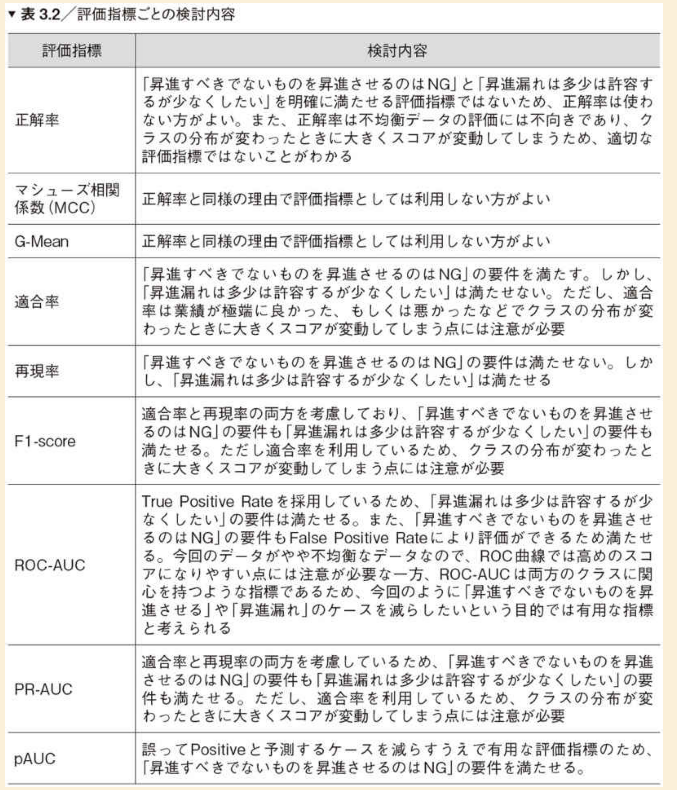

上記を踏まえると，今回のタスクにおいて単体で適切に使用できそうなのは
- ROC-AUC
- PR-AUC
- F1-Score
の3つである．

それぞれの要件を満たせる評価指標を1つずつ組み合わせれば,
- pAUC or Precision .. 昇進すべきでないものを昇進させない
- Recall .. 昇進漏れは少なくしたい
これらの指標を利用することも可能．


評価指標で何を使うか決める際のチートシート
- 確率予測に関心がある場合
    - クラスラベルが必要な場合
        - Posの方が重要 or 不均一データ -> `PR-AUC`
        - 両方のクラスが重要 -> `ROC-AUC`
    - 確率値だけが必要
- クラスラベルを予測することに関心がある場合
    - Posのほうが重要
        - FNとFPが等しく重要 -> `F1-score`
        - FNの方が重要 -> recall -> `F2-score`
        - FPの方が重要 -> precision -> `F0.5-score`
    - 両方のクラスに関心がある
        - 均一データ -> `Accuracy`
        - 不均衡データ -> `G-Mean` or `MCC`

ビジネスインパクトの試算
- 「指標ooの数値がxx以上でた！」と言っても，ビジネスサイドの人間が知りたいことは，「そのモデルをリリースすることでいくら儲かるの？」という話になる
- そもそも企業がデータサイエンティストを採用するのは，売上を上げるためであり，我々の仕事のインパクトがKPIにどのような影響を与えるのかを試算する必要がある

評価指標を計算するだけでは，その施策から生じる売上が計算できない
- ある商品のクーポン付きのDMを配布する施策を考え，その商品を購入するか否かの2値分類を考える
- 予測結果がTrue Positiveのとき，10000円の商品を購入してもらえるが，False Positiveだったときは80円のコストが発生する
- ここで評価指標のprecisionが1だったとする．つまり，Posと予測したものは全て当たっている．しかし，Recallが低く，TNが多いモデルであれば，DM送付数が少なくて，機会損失を生じている可能性がある．逆に，Reccallが高くても，False Posが多いモデルであれば，赤字になる

ビジネスインパクトの試算 - 1
- モデルの採用により発生するコスト$\hat{C}_{all}$は以下のように分解できる
    - $\hat{C}_{all} = \hat{C}_{human} + \hat{C}_{ops}$
        - $\hat{C}_{human}$ : モデルで昇給と判断された人の人事評価にかかる人件費 
        - $\hat{C}_{ops}$ : モデルの運用コスト
- 現在の運用により発生しているコストを$C_{all}$とすると, 現在の運用から削減できるコストは
    - $C_{all} - \hat{C}_{all}$で計算される
- 人事評価をする人はマネージャー相当であり，1人月のコストは200万円とする．また，現状評価には900人月かけているので，以下によって現状の評価にかかっているコストが計算できる
    - $C_{all} = 200万円/月 \times 900人月 ＝ 1,800百万円$
- このとき，採用を考えているモデルの各要素は以下であった

In [14]:
# ※ 今回のモデリングの結果

tp = 110 # 昇給すると予測し，実際に昇給した人数
fp = 60 # 昇給すると予測し，実際には昇給しなかった人数
tn = 16553 # 昇給しないと予測し，実際に昇給しなかった人数
fn = 1373 # 昇給しないと予測し，実際には昇給した人数

モデル採用時の人事評価コスト$\hat{C}_{human}$は，すべての社員のうちモデルがPositiveと判断した人だけを評価すること，仮に全社員の評価に4人月かかることから以下のように表現ができる
- $\hat{C}_{human} = \frac{TP+FP}{TP+FP+TN+FN}\cdot C_{all}$

In [15]:
c_all = 1_800_000_000
r = (tp + fp) / (tp + fp + tn + fn)
c_human_hat =  r * c_all
print(r)
print(c_human_hat)

0.009394341290893015
16909814.323607426


計算後の$\hat{C}_{human}$は16,909,814であった．ここからエンジニアの稼働単価を考慮する．1人月150万円だったとし，1日もあればこのモデリングができるとする．ローカルでの稼働を考え，インフラのコストは考慮しない．つまり，$\hat{C}_{ops} = 150万円 / 30日$で5万円とする．

つまり，$\hat{C}_{all} = 16,900,000 - 50,000$であり，約170万円となる．

当初のコストが1800百万円であることを考えると，このモデルの採用により，約99%のコスト削減が見込まれる．

さらに，考えるべきことがある．それは評価対象の人数が少なすぎること．

$FN = 1373$ を見ると，昇進すべき人を1373人見逃しており，多くの人が不適切な評価を受けている．このモデルは評価しないことのコストを考慮しているため，誰も評価しないことがコスト削減のために良いとしてしまっている．

しかし，評価しないことで発生するコスト．すなわち，
- 昇進すべき人を昇進した場合
    - その人がプロジェクトを推進することで会社にもたらす利益
- 昇進させてはいけない人を昇進させた場合
    - 無駄な人件費によるコスト
    - 未来の機会損失
- 昇進すべき人を昇進させなかった場合
    - 優秀な人の退職により，新たに人を採用するためのコスト

などが挙げられるが，これらのコストを正確に見積もることは非常に難しい

比較的簡単な例でビジネスインパクトの試算を行ってみる

- ハガキによるDM送付の例
    - ハガキによるDMの送付コスト問題について考える．これまで，A社は，顧客リストからランダムサンプリングした一定数の顧客に対してDMを送付し，過去のデータを蓄積している．今回は，これまでDMを送付していない顧客に対して送付することを考える．ここで，それぞれの顧客が購入するかしないかを予測するモデルを作成する．購入するを予測した顧客に対してDMを送付する．顧客はDMを受け取り，気になったものがあれば，近くの販売店で商品を購入するため，商品の配送料は考えない．話を簡単にするために，ハガキに記載されている商品は1種類のみで，税込みで1000円とする．また，DMを送るコストは100円である．

- まずは，TP，FP，TN，FNが，KPIである利益にどのような影響を与えるか整理する
    - True Positive : C_tp
        - モデルが購入すると予測した顧客が受け取って購入した
        - 発生する利益は1000 - 100 = 900円
    - False Positive : C_fp
        - モデルが購入すると予測した顧客が受け取って購入しなかった
        - 発生する利益は-100円
    - True Negative : C_tn
        - モデルが購入しないと予測した顧客が受け取って購入しなかった
        - 発生する利益は100円 (DM送付の必要がなくなったため)
    - False Negative : C_fn
        - モデルが購入しないと予測した顧客が受け取って購入した
        - 機会損失により利益は-900円
- コストを整理したものをコスト行列と呼ぶ
    - 実際には，FNによる機会損失を考慮せず0にするなど，実際に発生するコストだけを評価に加えた方が良いモデル位になる可能性もある
- 発生する利益の計算
    - モデルがPosと予測したときにのみDMを送ったときの利益
    - = TP * C_tp + FP * C_fp + TN * C_tn + FN * C_fn

In [16]:
C_tp = 900
C_fp = -100
C_tn = 100
C_fn = -900

# hr analyticsのときと同じデータを使ってみる
tp = 110 
fp = 60 
tn = 16553 
fn = 1373 

cost = C_tp * tp + C_fp * fp + C_tn * tn + C_fn * fn
print(cost)

512600


結果は，512600円の黒字となる

In [17]:
# 全員にDMを送ると，
cost = (tp+fn)*900 - 100 * (fp+tn)
print(cost)

-326600


全員にDMを送ると-326600円の赤字となるため，モデルを利用するか否かの判断は容易である．

送付対象の顧客リストが増えたとする．この場合，どの程度利益が見込めるのかを計算したい．

期待値の概念を導入しておく

期待値は，TP，FP，TN，FNのそれぞれに対して，それぞれの発生確率をかけたものを足し合わせたものである．

期待値の計算式

$$
p(TP) \cdot C(tp) + p(FP) \cdot C(fp) + p(TN) \cdot C(tn) + p(FN) \cdot C(fn)
$$

$p(TP)$は，TPが出る確率．$C(tp)$は，TPが出たときの利益である．

In [21]:
n_samples = tp + fp + tn + fn
print(n_samples)

p_tp = tp / n_samples
p_fp = fp / n_samples
p_tn = tn / n_samples
p_fn = fn / n_samples

print(f"p_tp = {p_tp:.3f}")
print(f"p_fp = {p_fp:.3f}")
print(f"p_tn = {p_tn:.3f}")
print(f"p_fn = {p_fn:.3f}")

# 期待値計算
expected = p_tp * C_tp + p_fp * C_fp + p_tn * C_tn + p_fn * C_fn
print(expected)

18096
p_tp = 0.006
p_fp = 0.003
p_tn = 0.915
p_fn = 0.076
28.32670203359858


これにより，顧客一人あたりの利益が28.32円くらいだと計算できる

例えば，顧客リストが20万人だとしたら，期待利益は以下のように見積もることができる

In [22]:
expected * 200_000

5665340.406719716

## banking_dataset

- 分類モデルによる判定は，閾値0.5を超えたかどうかで，評価を行ってきた．閾値を調整することで評価指標のスコアを高くするアプローチもあるが，ビジネスインパクトの期待値を計算することも可能
- Recallを使って閾値調整をすることを考える
    - 一般的なアプローチとして，必要最低限のPrecisionを担保し，Recallのスコアを高く閾値を調整する
- 評価使用自体は分類の正しさを評価しており，コストや期待値を無視すると，想定よりもKPIの上昇に寄与しずらいことがある
    - ビジネスインパクトの期待値を計算しておくことで，KPIへの寄与度を把握しておける
- 利益曲線
    - 横軸を閾値，縦軸をその閾値のときのビジネスインパクトの期待値を表したもの
    - ここでは，ビジネスインパクトの期待値を利用した閾値の調整方法として，利益曲線を描画する方法を実装する

- データセット
    - 年齢，業種，教育水準，電話によって定期預金を契約したかどうかなどをカラムに持つ
    - このデータで，定期預金の契約に至る可能性が最も高い顧客を特定したい
- コスト行列 (外注先のコールセンターの人件費がワンコールあたり200円かかるとする)
    - TP：契約による1人あたりの利益 = 10000 - 200 = 9800円
    - FP : 営業を無駄にしたコスト = -200円
    - TN : 何もしなくてもよいコスト = 0円
    - FN : 今回は機会損失をコストにしないこととする = 0円

In [2]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

In [7]:
def calc_expected_value(conf_matrix):
    """
    混同行列から期待値計算をする
    """
    TP_COST = 9800
    FP_COST = -200
    TN_COST = 0
    FN_COST = 0

    tp, fp, fn, tn = conf_matrix.ravel()

    n_samples = np.sum(conf_matrix)
    tp_rate = tp / n_samples
    fp_rate = fp / n_samples
    tn_rate = tn / n_samples
    fn_rate = fn / n_samples

    return tp_rate * TP_COST + fp_rate * FP_COST + tn_rate * TN_COST + fn_rate * FN_COST

def benefit_curve(clf_lst, X_val, y_val):
    for clf in clf_lst:
        y_val_hat_proba = clf.predict_proba(X_val)
        expected_value_list = []
        thr_list = []
        for proba in np.sort(y_val_hat_proba[:, 1]):
            y_val_hat = (y_val_hat_proba[:, 1] > proba).astype(int)
            conf_matrix = confusion_matrix(y_val, y_val_hat, labels=[1, 0])
            expected_value = calc_expected_value(conf_matrix)
            expected_value_list.append(expected_value)
            thr_list.append(proba)
        max_bene_index = expected_value_list.index(max(expected_value_list))
        plt.plot(thr_list, expected_value_list, label=f"{clf.__class__.__name__}")
        print(f"{clf.__class__.__name__} を使ったときに利益が最大になる閾値: {thr_list[max_bene_index]}")
    plt.xlabel('threshold')
    plt.ylabel('expected value')
    plt.legend(loc='upper right')
    plt.show()

def label_encoding(df):
    """
    文字列で表されたラベルを0~N-1に変換し上書きする
    N = ラベル種類数
    """
    object_type_cols = [col for col in df.columns if df[col].dtypes == 'object']
    for object_type_col in object_type_cols:
        label_encoder = LabelEncoder()
        df[object_type_col] = label_encoder.fit_transform(df[object_type_col])
    return df

def standard_scale(X_train, X_val):
    """ 特徴の標準化 """
    ss = StandardScaler()
    X_train_scaled = ss.fit_transform(X_train)  # トレーニングデータをフィットして変換
    X_val_scaled = ss.transform(X_val)  # 検証データを変換（トレーニングデータで学習したパラメータを使用）
    return X_train_scaled, X_val_scaled

def run_preprocess(df_train):
    # Nanが含まれている行を削除(ロジスティック回帰が動かないため)
    remove_cols = ['previous_year_rating', 'education']
    df_train.drop(remove_cols, axis=1, inplace=True)
    df_train = label_encoding(df_train)
    return df_train

LogisticRegression を使ったときに利益が最大になる閾値: 6.894261779625809e-05
GaussianNB を使ったときに利益が最大になる閾値: 6.736197576993259e-108


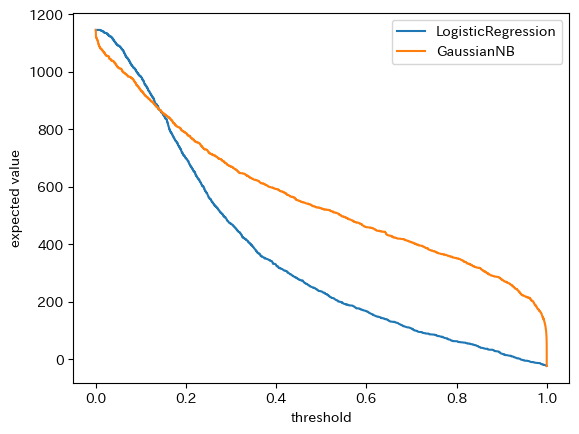

In [8]:
df_train = pd.read_csv('../data/banking_dataset/train.csv')
# print(df_train.shape)
df_train = label_encoding(df_train)
y = df_train['y'].values # 教師ラベル
df_train.drop('y', axis=1, inplace=True)

# 学習データと検証データに分離
X_train, X_val, y_train, y_val = train_test_split(df_train, y, test_size=0.33, random_state=RANDOM_STATE)
# 標準化
X_train, X_val = standard_scale(X_train, X_val)

clfs = []
for clf in [LogisticRegression(max_iter=200, random_state=RANDOM_STATE), GaussianNB()]:
    clf.fit(X_train, y_train)
    clfs.append(clf)

benefit_curve(clfs, X_val, y_val)

- 顧客一人あたりの利益の期待値 
- 2つのモデルの利益が最大になる閾値を計算すると，ロジスティック回帰モデルのほうが高いことが分かる
- 実際に，利益が最大となる閾値0.06あたりの混同行列を見てみる

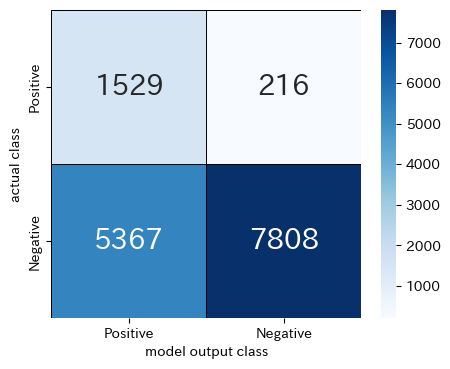

In [9]:
y_val_hat = (clf.predict_proba(X_val)[:, 1] > 0.06).astype(int)
conf_matrix = confusion_matrix(y_val, y_val_hat, labels=[1, 0])
df_conf_matric = pd.DataFrame(conf_matrix, columns=['Positive', 'Negative'], index=['Positive', 'Negative'])

plt.figure(figsize=(5,4))
sns.heatmap(
    df_conf_matric,
    fmt='d',
    annot=True,
    cmap='Blues',
    annot_kws={'fontsize': 20},
    linecolor='black',
    linewidths=0.5)
plt.xlabel('model output class')
plt.ylabel('actual class')
plt.show()

- コスト考慮型学習
    - コストを用いて期待値を得るコスト考慮学習というものがある
- コストの分解

||契約してくれる人|しない人|
|---|---|---|
|契約してもらえると判断|契約による利益|契約しない人に電話したことによる人件費|
|契約しないと判断|機会損失||


## 評価指標の性質を調べる

- 正解率 (Accuracy)
- 適合率 (Precision)
- 再現率 (Recall)
- マシューズ相関係数 (Matthews correlation coefficient)
- $F_{\beta}-score$
- F1-Score
- G-Mean
- ROC-AUC
- PR-AUC
- pAUC

### Accuracy


accuracyが高いように見えるが，実際に30件中25件ものPositiveを見逃してしまっている



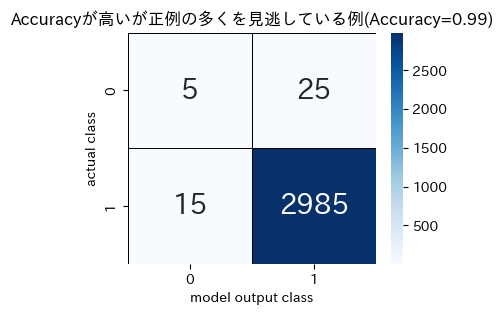

In [35]:
tmp = pd.DataFrame([[5,25],[15,2985]])
tp = tmp[0][0]
tn = tmp[1][1]
fp = tmp[1][0]
fn = tmp[0][1]
accuracy = (tp+tn) / (tp+fp+fn+tn)
# print(f"Accuracy = {accuracy:.2f}")
print("""
accuracyが高いように見えるが，実際に30件中25件ものPositiveを見逃してしまっている
""")
plt.figure(figsize=(4,3))
sns.heatmap(tmp,fmt='d',annot=True,cmap='Blues',annot_kws={'fontsize': 20},linecolor='black',linewidths=0.5)
plt.title(f"Accuracyが高いが正例の多くを見逃している例(Accuracy={accuracy:.2f})")
plt.xlabel('model output class')
plt.ylabel('actual class')
plt.show()


さらに極端な例
正例を全て見逃してい見ても高いAccuracyが出てしまう



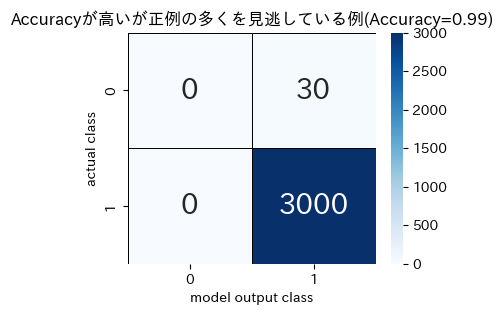

In [36]:
tmp = pd.DataFrame([[0,30],[0,3000]])
tp = tmp[0][0]
tn = tmp[1][1]
fp = tmp[1][0]
fn = tmp[0][1]
accuracy = (tp+tn) / (tp+fp+fn+tn)
# print(f"Accuracy = {accuracy:.2f}")
print("""
さらに極端な例
正例を全て見逃してい見ても高いAccuracyが出てしまう
""")
plt.figure(figsize=(4,3))
sns.heatmap(tmp,fmt='d',annot=True,cmap='Blues',annot_kws={'fontsize': 20},linecolor='black',linewidths=0.5)
plt.title(f"Accuracyが高いが正例の多くを見逃している例(Accuracy={accuracy:.2f})")
plt.xlabel('model output class')
plt.ylabel('actual class')
plt.show()

- マシューズ相関係数(Matthews Correlation Coefficient ; MCC)
    - $MCC = \frac{TP\cdot TN - FP\cdot FN}{(TP+FP)(TP+FN)(TN+FP)(TN+FN)}$ 
    - 式中には，TP・TN・FP・FNのすべてのパターンを評価に加えているため，Accuracyと同様に，PとFの両方のクラスに関心があるケースでよく用いられる
    - 式はTPとTNに関して可換である
    - 予測結果と真のクラスの相関係数を示し，$-1 \le MCC \le +1$であり，予測結果と正解クラスがすべて一致すると+1, 予測結果と真のクラスが全て不一致だと-1，ランダムな予測をしていると0を取る

- 適合率(Precision)
    - すべてのPositiveクラスのうち，モデルがどのくらいのPositiveを予測できたのかを表す指標で，精度とも呼ばれる
    - $Precision = \frac{TP}{TP + FP}$
    - Positiveと予測するもので精度を上げたい場合につかう
    - Negativeに関しては無視してよい場合

In [42]:
from sklearn.metrics import precision_score

precision = precision_score(y_val, y_val_hat)
print(f"precision = {precision:.2f}")

precision = 0.63


- 再現率(Recall，True Positive Rate; TPR)
    - $Recall = \frac{TP}{FN+TP}$
    - FN(False Nagetive)は，Negativeと予測して間違えた(False)であり，実際はPositiveであったがFalseに振り分けてしまった場合
    - Positiveの取りこぼしを避けたい場合に使う

In [43]:
from sklearn.metrics import recall_score

recall = recall_score(y_val, y_val_hat)
print(f"recall = {recall:.2f}") # recallが低い => Positiveクラスの分類漏れが多いモデルである

recall = 0.07


- $F_{\beta}-score$
    - $F_{\beta} = \frac{(1+\beta^2)\times Recall \times Precision}{(\beta^2\times Precision) + Recall}$
    - $\beta=1$のときに均衡し，$\beta=2$のとき，Precisionを優先．$\beta=0.5$のとき，Recallを優先という数値設定がよく使われる
    - ビジネスの性質でどちらを優先させるか決定
- $F_{1}-score$
    - RecallとPrecisionの調和平均
    - $F_{\beta}$における$\beta=1$のとき
    - FPとFNをどちらも同じくらいなくしたい．TNに関してはあまり関心が無い．こういうときに使いたい

In [44]:
from sklearn.metrics import f1_score

f1 = f1_score(y_val, y_val_hat)
print(f"f1_score = {f1:.2f}")

f1_score = 0.12


- G-Mean
    - $G-Mean = \sqrt{True Positive Rate \cdot True Negative Rate}$
        - $True Positive Rate = TP / (FN+TP)$
            - Positiveの予測漏れを計測
        - $True Negative Rate = TN / (FP+TN)$
            - Negativeの予測漏れを計測
        - 0 ~ 1の値を取り，1に近いほど良い
        - PosとNegの両方に関心がある場合に使う

In [46]:
import math

def g_mean_score(y, y_hat):
    # G-Meanを計算する
    tn, fp, fn, tp = confusion_matrix(y_val, y_val_hat).ravel()
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    return math.sqrt(tpr * tnr), tpr, tnr

In [48]:
gmean, tpr, tnr = g_mean_score(y_val, y_val_hat)
print(f"G-Mean = {gmean:.2f}")
print(f"True Positive Rate = {tpr:.4f}")
print(f"True Negative Rate = {tnr:.4f}") # Negの予測ばかり正しいモデルであり，G-meanが低い

G-Mean = 0.26
True Positive Rate = 0.0685
True Negative Rate = 0.9964


- ROC-AUC (ROC-Area Under the Curve)
    - ROC(Recceiver Operating Characteristic)曲線の下の面積
    - Pos/Negの予測閾値を変えたときのTPRとFPRの関係を示す曲線
    - $FPR = FalsePositiveRate = \frac{FP}{FP+TN}$
    - $TPR = TruePositiveRate = \frac{TP}{TP+FN}$
- ROC-AUCの特徴
    - 予測値を降順に並べたとき，上位に真のクラスがPosであるデータが偏っている．下位に真のクラスがNegであるデータが偏っているほと大きくなる
    - ROC曲線はクラスの分布の変化に影響されない
        - 評価に利用するデータの中でPosとNegのデータの割合が変わっても，ROC曲線は変わらない
    - PosとNegを判定するための閾値に依存しない

In [55]:
from sklearn.metrics import roc_auc_score

In [105]:
# 予測値を降順に並べたときの上位に真のクラスの偏りが無いケース

tmp1 = pd.DataFrame([
    [0.98, 0],
    [0.92, 1],
    [0.92, 0],
    [0.90, 1],
    [0.89, 0],
    [0.88, 1],
    [0.81, 0],
    [0.81, 1],
    [0.78, 0],
    [0.75, 0],
    [0.73, 0],
    [0.69, 0],
    [0.67, 0],
    [0.47, 1],
    [0.44, 0],
    [0.39, 1],
    [0.21, 0],
    [0.18, 1],
    [0.06, 0],
    [0.02, 1],
    [0.01, 0]],
    columns=['pred_score', 'actual_class'])
y_hat_score = tmp1['pred_score']
display(tmp1['actual_class'].value_counts())

0    13
1     8
Name: actual_class, dtype: int64

In [108]:
# 予測値を降順に並べたときの上位に真のクラスが1になっているデータが多いケース

tmp2 = pd.DataFrame([
    [0.98, 1],
    [0.92, 1],
    [0.92, 1],
    [0.90, 1],
    [0.89, 1],
    [0.88, 1],
    [0.81, 1],
    [0.81, 1],
    [0.78, 1],
    [0.75, 1],
    [0.73, 0],
    [0.69, 0],
    [0.67, 0],
    [0.47, 0],
    [0.44, 0],
    [0.39, 1],
    [0.21, 0],
    [0.18, 1],
    [0.06, 0],
    [0.02, 0],
    [0.01, 0]],
    columns=['pred_score', 'actual_class'])
y_hat_score = tmp2['pred_score']
display(tmp2['actual_class'].value_counts())

1    12
0     9
Name: actual_class, dtype: int64

In [111]:
# 予測値を降順に並べたときの上位に真のクラスが0になっているデータが多いケース

tmp3 = pd.DataFrame([
    [0.98, 0],
    [0.92, 0],
    [0.92, 0],
    [0.90, 0],
    [0.89, 0],
    [0.88, 1],
    [0.81, 0],
    [0.81, 0],
    [0.78, 0],
    [0.75, 0],
    [0.73, 0],
    [0.69, 0],
    [0.67, 1],
    [0.47, 1],
    [0.44, 1],
    [0.39, 1],
    [0.21, 1],
    [0.18, 1],
    [0.06, 1],
    [0.02, 1],
    [0.01, 1]],
    columns=['pred_score', 'actual_class'])
y_hat_score = tmp3['pred_score']
display(tmp3['actual_class'].value_counts())

0    11
1    10
Name: actual_class, dtype: int64

In [106]:
def plot_roc_curve(df):
    """ ROC曲線をプロットする """
    tpr = []
    fpr = []
    for threshold in np.sort(df['pred_score'].unique()):
        y_hat = (df['pred_score'] > threshold).astype(int)
        tn, fp, fn, tp = confusion_matrix(df['actual_class'], y_hat).ravel()
        tpr.append(tp / (tp + fn))
        fpr.append(fp / (fp + tn))
    plt.figure(figsize=(4,4))
    roc_auc = roc_auc_score(df['actual_class'], df['pred_score'])
    plt.plot(fpr, tpr, marker='o', markersize=3, label=f'ROC AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title('ROC Curve')
    plt.xlabel('FPR(False Positive Rate)')
    plt.ylabel('TPR(True Positive Rate)')
    plt.grid(ls='--')
    plt.legend(loc='upper left')
    plt.show()

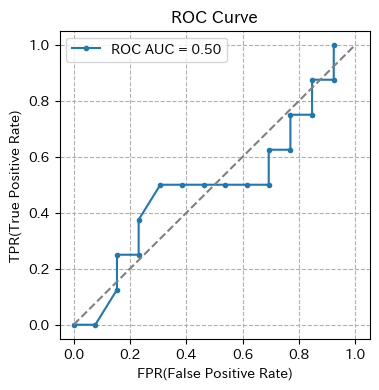

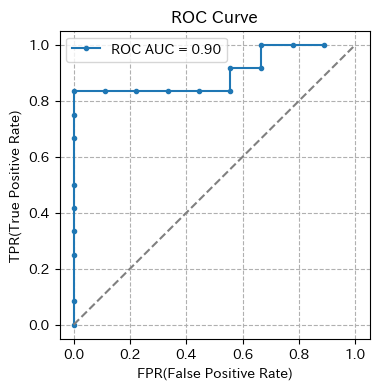

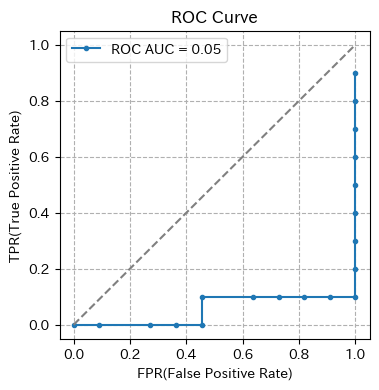

In [112]:
plot_roc_curve(tmp1)
print("""
予測値を降順に並べたときの上位に真のクラスに偏りが無いケース
ROC AUC = 0.5であり，ランダムな予測とほぼ変わらない
""")
plot_roc_curve(tmp2)
print("""
上位にある真のクラスがPositiveに偏っているケースケース
これは正しく予測したいPositiveをうまく予測できているモデル
""")
plot_roc_curve(tmp3)
print("""
予測値が高いほどNegativeに偏っているケース
これは好ましくない状況で，ランダムな予測よりも悪いと言える
""")